# Setup

**Imports**

In [ ]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences.

The signals have a varying number of symbols with a varying duration.
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [ ]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

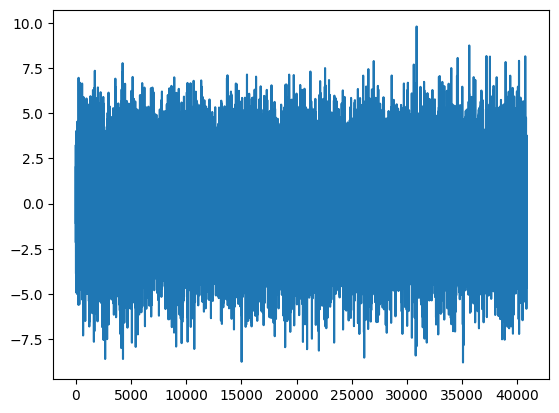

In [ ]:
plt.plot(X_train[2])

In [ ]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


# Question 2

In [ ]:
import numpy as np
import ruptures as rpt

def decode_symbol_sequence(signal, sampling_rate, low_freqs, high_freqs):
    """
    Decode a symbolic sequence from a signal using change-point detection.
    """
    n_samples = len(signal)
    time_step = 1 / sampling_rate

    model = "l2"
    algo = rpt.Pelt(model=model).fit(signal)
    change_points = algo.predict(pen=30)
    symbols = []
    for i in range(len(change_points) - 1):
        start, end = change_points[i], change_points[i + 1]
        segment = signal[start:end]

        if end - start < sampling_rate * 0.05:
            continue

        freqs = np.fft.rfftfreq(len(segment), time_step)
        fft_values = np.abs(np.fft.rfft(segment))

        low_freq = freqs[np.argmax([value if low_freqs[0] <= freq <= low_freqs[-1] else 0 for freq, value in zip(freqs, fft_values)])]
        high_freq = freqs[np.argmax([value if high_freqs[0] <= freq <= high_freqs[-1] else 0 for freq, value in zip(freqs, fft_values)])]

        symbol = map_frequencies_to_symbol(low_freq, high_freq)

        symbols.append(symbol)

    return symbols

def map_frequencies_to_symbol(low_freq, high_freq):
    """Map low and high frequencies to a DTMF symbol."""
    dtmf_table = {
        (697, 1209): "1", (697, 1336): "2", (697, 1477): "3", (697, 1633): "A",
        (770, 1209): "4", (770, 1336): "5", (770, 1477): "6", (770, 1633): "B",
        (852, 1209): "7", (852, 1336): "8", (852, 1477): "9", (852, 1633): "C",
        (941, 1209): "*", (941, 1336): "0", (941, 1477): "#", (941, 1633): "D",
    }

    low_tolerance = min(dtmf_table.keys(), key=lambda x: abs(x[0] - low_freq))[0]
    high_tolerance = min(dtmf_table.keys(), key=lambda x: abs(x[1] - high_freq))[1]

    return dtmf_table.get((low_tolerance, high_tolerance), "?")

sampling_rate = 22050
low_freqs = [697, 770, 852, 941]  # Low DTMF frequencies
high_freqs = [1209, 1336, 1477, 1633]  # High DTMF frequencies

test_signals = np.load("X_test.npy", allow_pickle=True).tolist()

sequences = [decode_symbol_sequence(signal, sampling_rate, low_freqs, high_freqs) for signal in test_signals]

print("Sequence 1:", sequences[0])
print("Sequence 2:", sequences[1])


Sequence 1: ['8', '2', '5', 'C', '9', '9', 'B']
Sequence 2: ['7', '8', '6', '0', '#', '#']


In [ ]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()
y_test = np.load("y_test.npy", allow_pickle=True).tolist()
y_test

[['7', '2', '1', 'C', '9', '9'], ['1', '#', '2', '#']]

# Question 3

<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\h'
<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:31: SyntaxWarning: invalid escape sequence '\h'
C:\Users\julie\AppData\Local\Temp\ipykernel_5292\1552862997.py:30: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$")
C:\Users\julie\AppData\Local\Temp\ipykernel_5292\1552862997.py:31: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("$\hat{g}_m(\lambda)$")


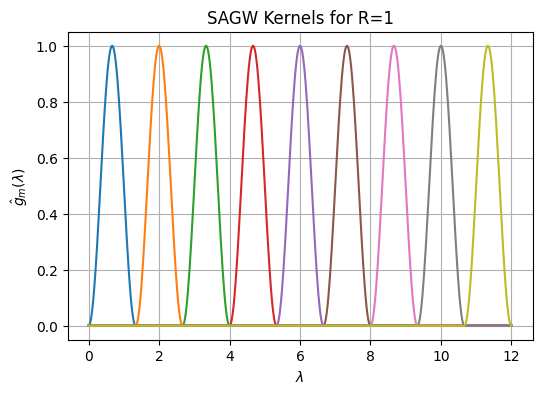

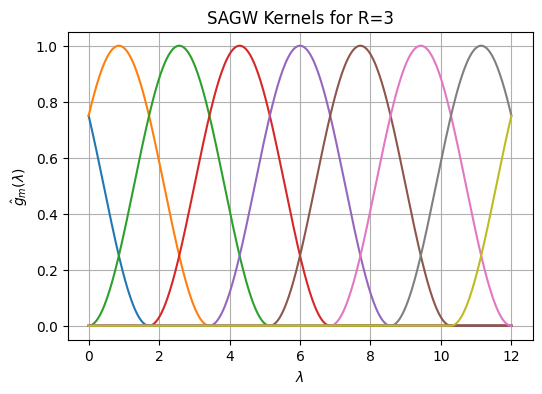

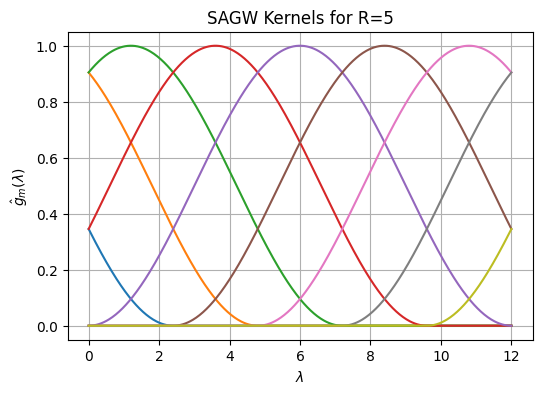

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

define_kernels = 9  # Number of scales
lambda_n = 12  # Maximum eigenvalue

def sagw_kernel(lambda_vals, R, M=9, lambda_n=12):
    """Compute the SAGW kernels."""
    a = lambda_n / (M + 1 - R)
    kernels = []
    for m in range(1, M + 1):
        shifted_lambda = lambda_vals - a * m
        kernel = 0.5 * (1 + np.cos(2 * np.pi * (shifted_lambda / (a * R) + 0.5)))
        kernel[(shifted_lambda < -a * R) | (shifted_lambda >= 0)] = 0
        kernels.append(kernel)
    return kernels

def plot_kernels(R_values, lambda_n):
    """Plot SAGW kernels for different values of R."""
    lambda_vals = np.linspace(0, lambda_n, 500)
    for i, R in enumerate(R_values):
        kernels = sagw_kernel(lambda_vals, R)
        plt.figure(figsize=(6, 4))
        for kernel in kernels:
            plt.plot(lambda_vals, kernel)
        plt.title(f"SAGW Kernels for R={R}")
        plt.xlabel("$\lambda$")
        plt.ylabel("$\hat{g}_m(\lambda)$")
        plt.grid(True)
        plt.savefig(f"kernel_{R}.png")
        plt.show()

R_values = [1, 3, 5]
plot_kernels(R_values, lambda_n)


In [5]:
!pip install loadmydata pygsp geopandas contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 20.5 MB/s eta 0:00:00


# Question 4

100%|██████████| 1.14M/1.14M [00:02<00:00, 422kiB/s]
100%|██████████| 5.06k/5.06k [00:00<00:00, 1.31MiB/s]
<ipython-input-6-d482eb09f152>:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothness_arr = np.array([float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals])


Where the signal is the least smooth: 2014-01-21 06:00:00
Where the signal is the smoothest: 2014-01-24 19:00:00


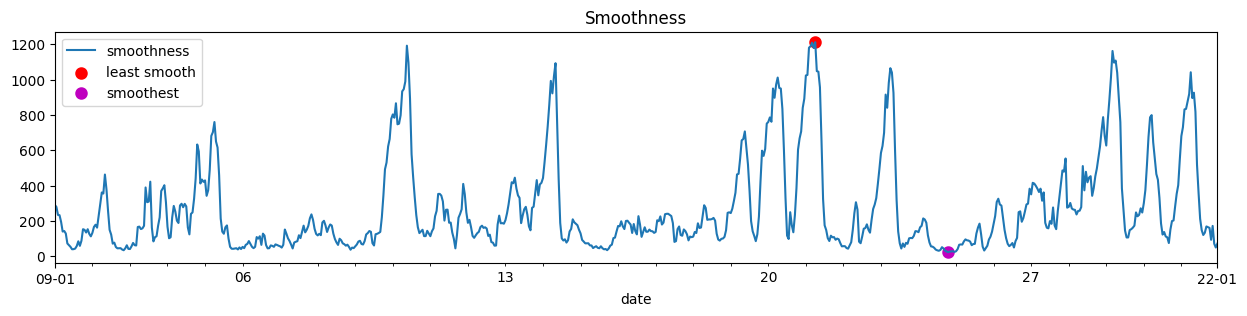

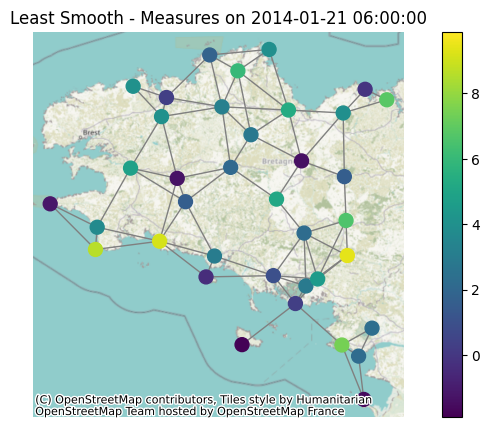

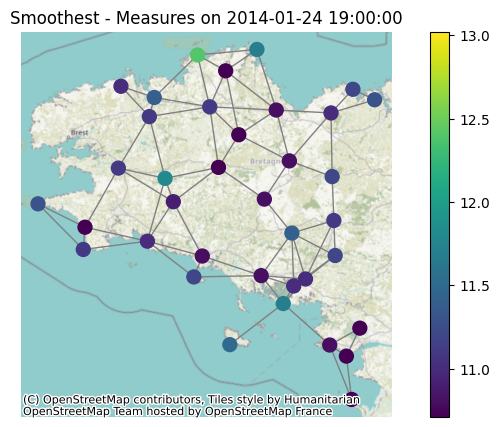

In [6]:
import numpy as np
import pandas as pd
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from math import asin, cos, radians, sin, sqrt
from scipy.spatial.distance import pdist, squareform
from pygsp import graphs
import matplotlib.pyplot as plt
import geopandas
import contextily as cx
import seaborn as sns
from matplotlib.dates import DateFormatter

data_df, stations_df, description = load_molene_meteo_dataset()
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temp_na = temperature_df.isna().sum(axis=0).sort_values(ascending=False)
to_remove = temp_na[temp_na > 0].index.tolist()
stations_df = stations_df[~stations_df.Nom.isin(to_remove)]

def get_geodesic_distance(point_1, point_2) -> float:
    lon1, lat1 = point_1
    lon2, lat2 = point_2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix ** 2) / bandwidth / bandwidth)
    return np.where(exp_similarity > threshold, exp_similarity, 0.0)

sigma = np.median(dist_mat_condensed)
threshold_to_try = np.arange(0, 1, 1 / 100)

average_degrees, is_connected = [], []

for threshold in threshold_to_try:
    adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
    average_degrees.append(np.mean(np.sum(adjacency_matrix_gaussian, axis=1)))
    G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
    is_connected.append(G_gaussian.is_connected(recompute=True))

for index_to_try in np.where(np.array(average_degrees) > 3)[0][::-1]:
    if is_connected[index_to_try]:
        threshold = threshold_to_try[index_to_try]
        average_degree = average_degrees[index_to_try]
        break

to_keep = list(set(data_df.station_name.unique().tolist()) - set(to_remove))
temperature_df_tokeep = temperature_df[to_keep]
adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
laplacian_matrix = G_gaussian.L.todense()
signals = temperature_df_tokeep.to_numpy()
smoothness_arr = np.array([float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals])
smoothness_df = pd.Series(data=smoothness_arr, index=temperature_df_tokeep.index)
index_argmin = smoothness_df.argmin()
index_argmax = smoothness_df.argmax()

print(f'Where the signal is the least smooth: {smoothness_df.index[index_argmax]}')
print(f'Where the signal is the smoothest: {smoothness_df.index[index_argmin]}')

fig, ax = plt.subplots(figsize=(15, 3))
smoothness_df.plot(ax=ax, label='smoothness')
plt.scatter(smoothness_df.index[index_argmax], np.max(smoothness_df), c='r', label='least smooth', lw=3)
plt.scatter(smoothness_df.index[index_argmin], np.min(smoothness_df), c='m', label='smoothest', lw=3)
plt.legend()
ax.xaxis.set_major_formatter(DateFormatter("%d-%m"))
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")
plt.savefig('smoothness.png', bbox_inches='tight')

signal = temperature_df_tokeep.iloc[index_argmax].to_numpy()
stations_gdf = geopandas.GeoDataFrame(stations_df, geometry=geopandas.points_from_xy(stations_df.Longitude, stations_df.Latitude))
stations_gdf.set_crs("EPSG:4326", inplace=True)
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal, ax=ax)
plt.title(f"Least Smooth - Measures on {temperature_df_tokeep.index[index_argmax]}")
plt.savefig('least_smooth.png')
plt.show()

signal = temperature_df_tokeep.iloc[index_argmin].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal, ax=ax)
plt.title(f"Smoothest - Measures on {temperature_df_tokeep.index[index_argmin]}")
plt.savefig('smoothest.png')
plt.show()

# Question 5

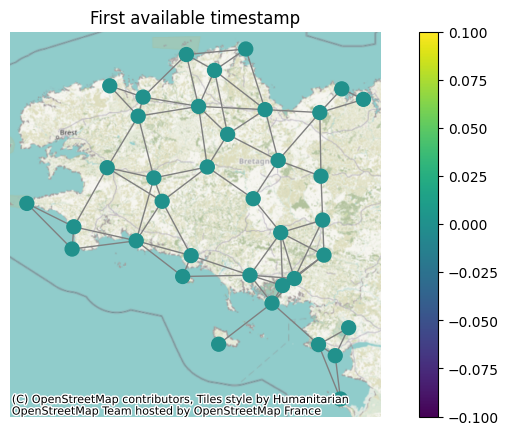

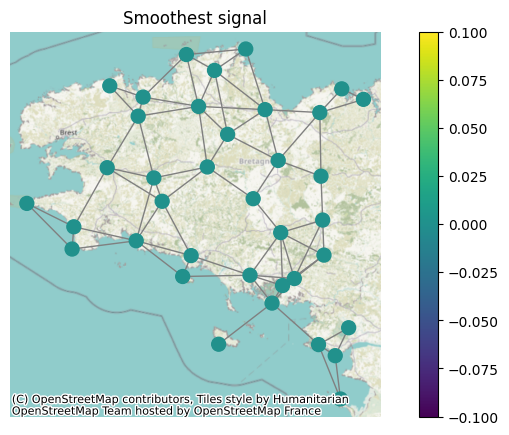

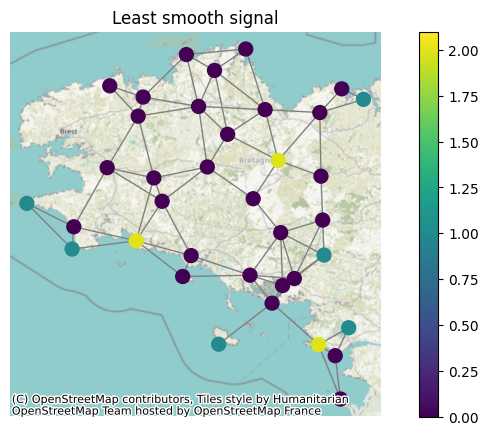

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
import scipy

adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
laplacian_matrix = G_gaussian.L.todense()

eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian_matrix)
index_sort = np.argsort(eigenvalues)
eigenvalues = eigenvalues.real[index_sort]
eigenvectors = eigenvectors[:, index_sort]

def get_g_m(eigenvalues, a, m, R):
    return np.exp(-((eigenvalues - (a * (m - R))) ** 2))

R = 3
M = 9
m_list = np.arange(1, M + 1)
a = eigenvalues[-1] / (M + 1 - R)

def classify_nodes(signal, eigenvectors, eigenvalues, a, m_list):
    signal_ft = eigenvectors.T @ signal
    labels = []

    for v in range(signal.shape[0]):
        W_v = []
        for m in m_list:
            W_v_m = np.sum(get_g_m(eigenvalues, a, m, R) * signal_ft * eigenvectors[v, :])
            W_v.append(W_v_m)

        labels.append(np.argmax([
            np.sum(np.array(W_v[:3])**2),  # Low frequency
            np.sum(np.array(W_v[3:6])**2),  # Medium frequency
            np.sum(np.array(W_v[6:9])**2)   # High frequency
        ]))

    return np.array(labels)

def plot_classification(labels, title, filename):
    ax = stations_gdf.geometry.plot(figsize=(10, 5))
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    G_gaussian.set_coordinates(stations_np)
    G_gaussian.plot_signal(labels, ax=ax)
    ax.set_title(title)
    plt.savefig(filename, bbox_inches="tight")
    plt.show()

signals_to_analyze = {
    "First available timestamp": temperature_df_tokeep.loc[temperature_df_tokeep.index[0]],
    "Smoothest signal": temperature_df_tokeep.loc[temperature_df_tokeep.index[smoothness_df.argmin()]],
    "Least smooth signal": temperature_df_tokeep.loc[temperature_df_tokeep.index[smoothness_df.argmax()]],
}

for title, signal in signals_to_analyze.items():
    signal = np.array(signal)
    labels = classify_nodes(signal, eigenvectors, eigenvalues, a, m_list)
    plot_classification(labels, title, f"{title.replace(' ', '_').lower()}.png")


# Question 6

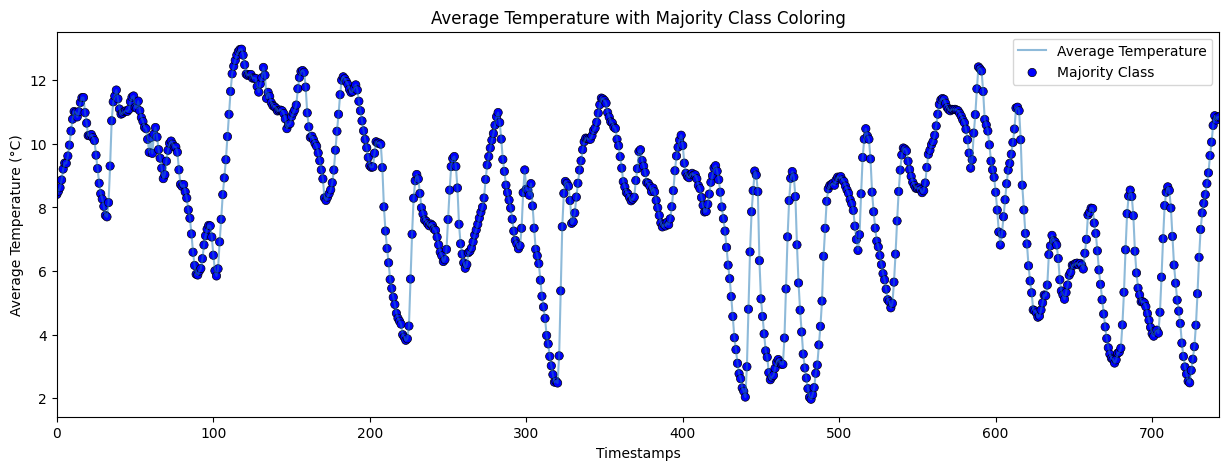

In [8]:
import collections
import matplotlib.pyplot as plt
import numpy as np

def get_freq_label(timestamp_index):
    """
    From a given timestamp index, return the majority class in the graph.
    """
    signal = np.array(temperature_df_tokeep.loc[temperature_df_tokeep.index[timestamp_index]])
    signal_ft = eigenvectors.T @ signal
    labels = []

    for v in range(signal.shape[0]):
        W_v = []
        for m in m_list:
            W_v_m = np.sum(get_g_m(eigenvalues, a, m, R) * signal_ft * eigenvectors[v, :])
            W_v.append(W_v_m)

        labels.append(np.argmax([
            np.sum(np.array(W_v[:3])**2),  # Low frequency
            np.sum(np.array(W_v[3:6])**2),  # Medium frequency
            np.sum(np.array(W_v[6:9])**2)   # High frequency
        ]))

    count_labels = collections.Counter(labels)

    majority_class = max(count_labels, key=count_labels.get)
    return majority_class

class_array = [get_freq_label(idx) for idx in range(temperature_df_tokeep.shape[0])]

def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

y = temperature_df_tokeep.mean(axis=1)
x = np.arange(y.shape[0])

colors = ["b", "m", "r"]  # Blue for low, magenta for medium, red for high frequency
color_array = np.take(colors, class_array)

fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5, label="Average Temperature")
ax.scatter(x, y, c=color_array, label="Majority Class", edgecolors="k", linewidths=0.5)
ax.set_xlabel("Timestamps")
ax.set_ylabel("Average Temperature (°C)")
ax.set_title("Average Temperature with Majority Class Coloring")
plt.legend()
plt.savefig('temp_q6.png', bbox_inches='tight')
plt.show()


# Question 7

Shape of the signal : (744, 37)


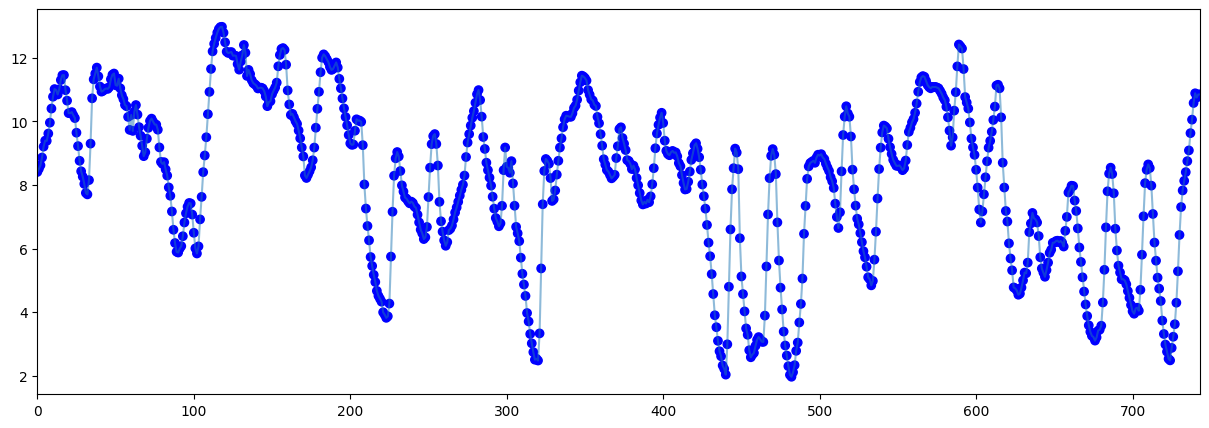

In [9]:
print(f'Shape of the signal : {signals.shape}')
nb_nodes, dim_t  = signals.shape

eigenvalues, eigenvectors = scipy.linalg.eigh(G_gaussian.L.todense())
eigenvectors = eigenvectors.astype(np.float32)
Lap_t =  - np.eye(nb_nodes, nb_nodes, 1) - np.eye(nb_nodes, nb_nodes, 1).T + np.eye(nb_nodes)
Lap_t[1:-1, 1:-1] = np.eye(nb_nodes - 2) + Lap_t[1:-1, 1:-1]
eigenvalues_time, eigenvectors_time = scipy.linalg.eigh(Lap_t)
eigenvectors_time = eigenvectors_time.astype(np.float32)
eigenvalues_H = np.kron(eigenvalues_time, np.ones(dim_t)) + np.kron(np.ones(nb_nodes), eigenvalues)
eigenvectors_H = np.kron(eigenvectors_time, eigenvectors)

signal_ft = eigenvectors_H.T @ signals.flatten()
labels = []
M, R = 11, 3
a = eigenvalues_H[-1]/(M + 1 - R)

for v in range(nb_nodes*dim_t):
  W_v = []
  for m in m_list:
    W_v_m = np.sum(get_g_m(eigenvalues_H, a, m, R)*signal_ft*eigenvectors_H[v, :])
    W_v.append(W_v_m)
  labels.append(np.argmax([np.sum(np.array(W_v[:3])**2), np.sum(np.array(W_v[3:6])**2), np.sum(np.array(W_v[6:9])**2)]))
assert len(labels) == nb_nodes*dim_t

labels_per_node = np.array(labels).reshape((nb_nodes, dim_t))
class_array = np.zeros(labels_per_node.shape[0])
for i, labels_current in enumerate(labels_per_node):
    count_labels = collections.Counter(labels_current)
    majority_class = np.argmax([x[1] for x in count_labels.items()])
    class_array[i] = majority_class
y = temperature_df_tokeep.mean(axis=1)
x = np.arange(y.shape[0])

colors = ["b", "m", "r"]
color_array = np.take(colors, list(class_array))
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
ax.scatter(x, y, c=color_array)

plt.savefig('temp_q7.png', bbox_inches = 'tight')